In [ ]:
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.cluster import KMeans
import scipy as sc
from sklearn.metrics.pairwise import rbf_kernel as rbf
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics.cluster import pair_confusion_matrix
import math
import warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Splitting The Data
The data is initially split to 6 partitions:
- 10% Training Data and its labels.
- Correction Testing Data and its labels.
- Full Data for Spectral Clustering and its labels.

In [ ]:
def loadData():
  trainingData =  pd.read_csv('drive/MyDrive/Anomaly Detection Data/kddcup.data_10_percent', sep=",", header = None)
  trainingDataSpectral =  pd.read_csv('drive/MyDrive/Anomaly Detection Data/kddcup.data/kddcup.data', sep=",", header = None)
  testingData = pd.read_csv('drive/MyDrive/Anomaly Detection Data/corrected/corrected', sep=",", header = None)
  stringCols = [1, 2, 3, 41]
  for i in stringCols:
    trainingData[i] = pd.factorize(trainingData[i])[0]
    testingData[i] = pd.factorize(testingData[i])[0]
    trainingDataSpectral[i] = pd.factorize(trainingDataSpectral[i])[0]
  
  return trainingData.loc[:,0:40], trainingData.loc[:, 41:], testingData.loc[:,0:40], testingData.loc[:, 41:], trainingDataSpectral

In [ ]:
trainingData, trainingLabels, testingData, testingLabels, totalDataSpectral = loadData()

The following subsidiary function reduces the dimensions of our clustering so that we can visualize it. \
Source is [here](https://github.com/dataquestio/project-walkthroughs/blob/master/kmeans/clustering.ipynb).

In [ ]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()

In [ ]:
def conditionalEntropy(predictedLabels, trueLabels, K):
  predictedLabeledClusters = [[] for _ in range(K)]
  for i in range(len(predictedLabels)):
      predictedLabeledClusters[predictedLabels[i]].append(trueLabels[i])
          
  entropy = np.zeros(K)
  N = 0

  for i in range(len(predictedLabeledClusters)):
    N += len(predictedLabeledClusters[i])
    count = np.zeros(K)
    for j in range(len(predictedLabeledClusters)):
      for k in range(len(predictedLabeledClusters[i])):
        if j == predictedLabeledClusters[i][k]:
          count[j] += 1
    for j in range(len(predictedLabeledClusters)):     
      if count[j] != 0:
        entropy[i] += (- count[j]/len(predictedLabeledClusters[i])) * math.log(count[j]/len(predictedLabeledClusters[i]))

  totalEntropy = 0
  for i in range(len(predictedLabeledClusters)):
    totalEntropy += (len(predictedLabeledClusters[i]) / N) * entropy[i]

  return totalEntropy

In [ ]:
def checkClustering(resultingLabels, trueLabels, K):
  confusionMat = pair_confusion_matrix(trueLabels, resultingLabels)
  precision = confusionMat[1][1] / (confusionMat[1][1] + confusionMat[0][1])
  recall = confusionMat[1][1] / (confusionMat[1][1] + confusionMat[1][0])
  f1score = 2 * precision * recall / (precision + recall)
  print("Precision Score: " , precision)
  print("Recall Score: " , recall)
  print("F Score: " , f1score)
  print("Conditional Entropy: " , conditionalEntropy(resultingLabels, trueLabels, K))

# K-Means
The following function applies K-Means clustering algorithm on our data with a given K value, and uses an epsilon + a given number of iterations to know when to stop. \


In [ ]:
def kMeans(data, k, epsilon, iterations):
  n_rows = data.shape[0]
  random_idx = np.random.RandomState(42).permutation(n_rows)
  centroids = data[random_idx[:k]]
  clusters = np.zeros(n_rows)
  proximityMatrix = np.zeros((n_rows, k))
  delta = np.inf
  iteration = 0
  while delta > epsilon and iteration < iterations:
    for i in range(k):
      proximityMatrix[:,i] = np.linalg.norm(data - centroids[i], axis=1)
      
    clusters = np.argmin(proximityMatrix, axis = 1)

    # plot_clusters(data[:,0:k], clusters, centroids, iteration)
    iteration += 1
    old_centroids = deepcopy(centroids)
    
    for i in range(k):
      centroids[i,:] = np.mean(data[clusters == i,:], axis = 0)
      if np.isnan(centroids).any():
        centroids[i] = old_centroids[i]

    delta = np.linalg.norm(centroids - old_centroids)
  
  return clusters, centroids

In [ ]:
def predict(centroids, data):
  k = len(centroids)
  n = data.shape[0]
  proximityMatrix = np.zeros((n, k))
  for i in range(k):
    proximityMatrix[:,i] = np.linalg.norm(data - centroids[i], axis=1)
  predicted_labels = np.argmin(proximityMatrix, axis=1)
  return predicted_labels

## For K = 7

In [ ]:
clusteringResults = []
centroidsResults = []
kArray = [7, 15, 23, 31, 45]

clusters, centroids = kMeans(trainingData.to_numpy(), 7, 0.001, 200)
clusteringResults.append(clusters)
centroidsResults.append(centroids)


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [ ]:
checkClustering(clusters, trainingLabels.to_numpy()[:,0], 7)

Precision Score:  0.4129711548896276
Recall Score:  0.9994729305334826
F Score:  0.5844528568076929
Conditional Entropy:  0.9699993565789685


## For K = 15

In [ ]:
clusters, centroids = kMeans(trainingData.to_numpy(), 15, 0.001, 200)
clusteringResults.append(clusters)
centroidsResults.append(centroids)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [ ]:
checkClustering(clusters, trainingLabels.to_numpy()[:,0], 15)

Precision Score:  0.7635707073254366
Recall Score:  0.7240546260877776
F Score:  0.7432878300285443
Conditional Entropy:  0.38024670541929567


## For K = 23

In [ ]:
clusters, centroids = kMeans(trainingData.to_numpy(), 23, 0.001, 200)
clusteringResults.append(clusters)
centroidsResults.append(centroids)

In [ ]:
checkClustering(clusters, trainingLabels.to_numpy()[:,0], 23)

Precision Score:  0.8212840056699517
Recall Score:  0.6917162397121144
F Score:  0.7509522696663742
Conditional Entropy:  0.3053563932327014


## For K = 31

In [ ]:
clusters, centroids = kMeans(trainingData.to_numpy(), 31, 0.001, 200)
clusteringResults.append(clusters)
centroidsResults.append(centroids)

In [ ]:
checkClustering(clusters, trainingLabels.to_numpy()[:,0], 31)

Precision Score:  0.8738977287205428
Recall Score:  0.6725591352273431
F Score:  0.7601219463761701
Conditional Entropy:  0.23864945903152385


## For K = 45

In [ ]:
clusters, centroids = kMeans(trainingData.to_numpy(), 45, 0.001, 200)
clusteringResults.append(clusters)
centroidsResults.append(centroids)

In [ ]:
checkClustering(clusters, trainingLabels.to_numpy()[:,0], 45)

Precision Score:  0.9754999969715636
Recall Score:  0.6610362086993504
F Score:  0.7880556719121915
Conditional Entropy:  0.0977794619613127


In [ ]:
warnings.filterwarnings("ignore")
actual_labels = testingLabels.to_numpy().flatten()
for k in kArray:
  clusters, centroids = kMeans(trainingData.to_numpy(), k, 0.001, 200)
  predicted_labels = predict(centroids, testingData)
  print(f'K-Means with k={k}')
  checkClustering(predicted_labels, actual_labels, k)
  print()

K-Means with k=7
Precision Score:  0.35724224700025636
Recall Score:  0.9994639263064989
F Score:  0.5263493980559961
Conditional Entropy:  0.7512333969826389

K-Means with k=15
Precision Score:  0.6311021489567514
Recall Score:  0.6146898689806143
F Score:  0.6227878998581184
Conditional Entropy:  0.3720591818015853

K-Means with k=23
Precision Score:  0.6227486330572504
Recall Score:  0.4462170403306566
F Score:  0.5199064082798301
Conditional Entropy:  0.3981877037228226

K-Means with k=31
Precision Score:  0.7286580436816733
Recall Score:  0.42186554122561254
F Score:  0.5343579636239033
Conditional Entropy:  0.42213098103853636

K-Means with k=45
Precision Score:  0.9218192366460805
Recall Score:  0.36134602791237447
F Score:  0.5191782053575126
Conditional Entropy:  0.24592909396855236



# Generating Our Test Bed
Since the data is relatively huge and can't be processed with our current resources, we have to take a portion of it.

In [ ]:
X_train_spectral, _ = train_test_split( totalDataSpectral, train_size=0.0015, random_state=42)
X_train_meanShift, _ = train_test_split( totalDataSpectral, train_size=0.00015, random_state=42)
print(X_train_spectral.shape)
print(X_train_meanShift.shape)


spectral_train = X_train_spectral.loc[:,0:40]
spectral_labels = X_train_spectral.loc[:, 41:]
meanShift_train = X_train_meanShift.loc[:,0:40]
meanShift_labels = X_train_meanShift.loc[:, 41:]

print(spectral_train.shape)
print(spectral_labels.shape)
print(meanShift_train.shape)
print(meanShift_labels.shape)
print(meanShift_labels)

(7347, 42)
(734, 42)

(7347, 41)
(7347, 1)
(734, 41)
(734, 1)
         41
3125354   5
2283869   5
1222869   4
4068472   5
2906158   5
...      ..
1136074   4
1570006   5
2234489   5
4304572   5
1692743   5

[734 rows x 1 columns]


# Spectral Clustering Using K-Ways Normalized Cut


In [ ]:
def SpectralClustering(data, clustersNumber, gammaValue = 1):
    similarityMatrix = rbf(data,gamma=gammaValue)
    degreeMatrix = np.diag(np.sum(similarityMatrix, axis=1))
    laplacianMatrix = degreeMatrix - similarityMatrix
    normAsymLaplacianMatrix = np.dot(sc.linalg.inv(degreeMatrix), laplacianMatrix) 
    eigenValues,eigenVectors = sc.linalg.eig(normAsymLaplacianMatrix)
    eigenValues =  np.abs(np.real(eigenValues))
    eigenVectors = np.real(eigenVectors)
    sort_perm = eigenValues.argsort()
    eigenValues = eigenValues[sort_perm]
    eigenVectors = eigenVectors[:, sort_perm]
    eigenValues = eigenValues[:clustersNumber]
    U = eigenVectors[:, :clustersNumber]
    Y = normalize(U, axis=1)
    labels = KMeans(n_clusters=clustersNumber,  n_init="auto", random_state=42).fit_predict(Y)
    return eigenValues, Y, labels

Compute K means at K = 23 with the spectral clustering data

In [ ]:
clusters, centroids = kMeans(spectral_train.to_numpy(), 11, 0.1, 100)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [ ]:
checkClustering(clusters, spectral_labels.to_numpy()[:,0], 11)

Precision Score:  0.8034840002908602
Recall Score:  0.7236731088182282
F Score:  0.7614930525588222
Conditional Entropy:  0.2934591939654197


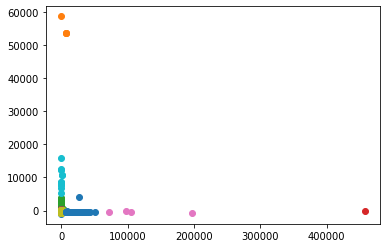

In [ ]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
 
#Load Data
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(X_train_spectral)
 
df.shape

#Getting unique labels
 
u_labels = np.unique(clusters)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[clusters == i , 0] , df[clusters == i , 1] , label = i)
plt.show()
# plot_clusters(X_train, clusters, centroids, 1)

In [ ]:
eigenValues, Y, labels = SpectralClustering(spectral_train, 11)

In [ ]:
checkClustering(labels, spectral_labels.to_numpy()[:,0], 11)

Precision Score:  0.42102036866963566
Recall Score:  0.9987381955394088
F Score:  0.5923389143628169
Conditional Entropy:  0.9945877855600728


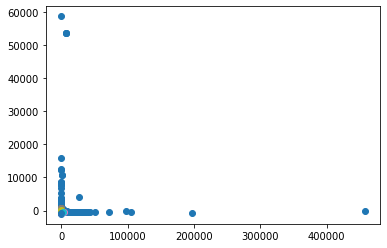

In [ ]:
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(X_train_spectral)
 
df.shape

#Getting unique labels
 
u_labels = np.unique(labels)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[labels == i , 0] , df[labels == i , 1] , label = i)
plt.show()

# Mean Shift Algorithm


In [ ]:
def mean_shift(data, bandwidth = None, bandwidthStep = 100):

  if bandwidth is None:
    all_data_centroid = np.average(data,axis=0)
    all_data_norm = np.linalg.norm(all_data_centroid)
    bandwidth = all_data_norm/bandwidthStep

  centroids = {}

  for i in range(len(data)):
    centroids[i] = data[i]

  weights = [i for i in range(bandwidthStep)][::-1]    
  while True:
    new_centroids = []
    for i in centroids:
      in_bandwidth = []
      centroid = centroids[i]
                
      for featureset in data:

        distance = np.linalg.norm(featureset-centroid)
        if distance == 0:
          distance = 0.00000000001
        weight_index = int(distance/bandwidth)
        if weight_index > bandwidthStep - 1:
          weight_index = bandwidthStep - 1

        to_add = (weights[weight_index]**2)*[featureset]
        in_bandwidth +=to_add

      new_centroid = np.average(in_bandwidth,axis=0)
      new_centroids.append(tuple(new_centroid))

    uniques = sorted(list(set(new_centroids)))

    to_pop = []

    for i in uniques:
      for j in [i for i in uniques]:
        if i == j:
            pass
        elif np.linalg.norm(np.array(i)-np.array(j)) <= bandwidth:
          to_pop.append(j)
          break

    for i in to_pop:
      try:
        uniques.remove(i)
      except:
        pass

    prev_centroids = dict(centroids)
    centroids = {}
    for i in range(len(uniques)):
      centroids[i] = np.array(uniques[i])
        
    optimized = True

    for i in centroids:
      if not np.array_equal(centroids[i], prev_centroids[i]):
        optimized = False

    if optimized:
      break
            
  proximityMatrix = np.zeros((data.shape[0], len(centroids)))
  for i in range(len(centroids)):
      proximityMatrix[:,i] = np.linalg.norm(data - centroids[i], axis=1)
      
  clusters = np.argmin(proximityMatrix, axis = 1)

  return clusters

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import metrics

estimatedBandwidth = estimate_bandwidth(X_train_meanShift.to_numpy(), quantile=0.5, random_state=42)
meanShiftClustering = MeanShift(bandwidth=estimatedBandwidth).fit_predict(X_train_meanShift.to_numpy())
print(estimatedBandwidth)
print(meanShiftClustering[:1000])
print(set(meanShiftClustering))


1268.7673178892749
[ 0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  

In [ ]:
meanShiftClustering = mean_shift(meanShift_train.to_numpy())

print(meanShiftClustering[:1000])
print(set(meanShiftClustering))


[ 8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  5  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  7  5
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  4
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  4  8  9  8  8  8
  8  7  8  8  8  8  8  8  8  8  5  8  8  8  8  4  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  3  8  8  8  8  7  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  7  8  7  8  8  8  8  8  8  8  8
  8  8  5  8  8  8  8  8  8  8  8  2  8  8  8  8  8  8  8  8  8  8  8  4
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  7  8  8  8  8  8  8  8  4  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  7  8  8  8  8  8  8  8  8  8  8  7  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  7  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  7  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  7  8  8  8  8  8  8

In [ ]:
checkClustering(meanShiftClustering, meanShift_labels.to_numpy()[:,0], 12)

Precision Score:  0.47576078664067134
Recall Score:  0.9584108877922166
F Score:  0.6358713200514358
Conditional Entropy:  0.8557752609213186


Refrences:
https://www.youtube.com/watch?v=k1alPDpSGBE&list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v&index=42

